# TEK4050 V21 - PROJECT ASSIGNMENT
## Olav Fønstelien 2021-05-08

# Introduction
In this project we will investigate the Kalman filter applied on a simple physical model.


We will simulate a very simple system consisting of a cart driven by a DC motor. The states of the system are the cart's _position_ $x_1$, its _velocity_ $x_2$, and the applied _armature current_ $x_3$, such that the state vector is given by
$$
\mathbf{x} = 
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}.
$$

To model this system, we must establish the relationship between the state variables. For the position and velocity, the relationship is simply 
$$
\dot{x}_1 = x_2.
$$

For the velocity and the armature current, we begin by investigating the forces acting on the cart. They are the driving force $F_M$ developed by the electric motor, and the opposing friction $F_r$. In sum, the cart's acceleration is given by
$$
\dot{x}_2 = \frac{F_M - F_r}{m},
$$
where $m$ is the mass of the cart. The motor force is proportional to the torque, $T_M$, and the torque developed by DC motor is again proportional to the applied armature current, such that
$$
F_M = k_M T_M = k_M'x_3.
$$
Here, $k_M$ contains all factors relating to the mechanical transmission of power from the rotor to the surface which the cart's wheels are rubbing against, while $k_M'$ in addition to that accounts for the electromagnetics, such as flux density, rotor area and physical constants. In the case we are studying here, the friction increases linearly with velocity;
$$
F_r = k_r x_2,
$$
where $k_r$ is the friction constant. This kind of friction is typical for an object moving slowly through a viscous without creating turbulence. The resulting relationship between velocity and armature current is
$$
\dot{x}_2 = \frac{-k_r}{m}x_2 + \frac{k_M'}{m}x_3.
$$

Moving on to the armature current equation, we note that we can only control the cart's position and velocity through current. A step change in setpoint from a steady-state $u^-$ to $u^+$ at time $t=0$ gives an exponential response in the armature current due to electrical impedance, such that
$$
x_3 = u^- + \big( 1 - e^{-t/\tau_a} \big) \big( u^+ - u^- \big), \quad t \ge 0.
$$
Time derivation gives us
$$
\dot{x}_3 = \frac{1}{\tau_a} \bigg[ \big( u^+ - u^- \big)e^{-t/\tau_a} \bigg],
$$
and rearranging the equation for $x_3$ above gives us that
$$
x_3 = u^+ - \bigg[ \big( u^+ - u^- \big)e^{-t/\tau_a} \bigg] = u^+ - \tau_a \dot{x}_3,
$$
which results in
$$
\dot{x}_3 = \frac{-1}{\tau_a} x_3 + \frac{1}{\tau_a} u^+.
$$

Finally, the system equiation becomes
$$
\dot{\mathbf{x}} = \mathbf{F}\mathbf{x} + \mathbf{L}u
\quad \Rightarrow \quad
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 \\
0 & \frac{-k_r}{m} & \frac{k_M'}{m} \\
0 & 0 & \frac{-1}{\tau_a}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 0 \\ \frac{1}{\tau_a}
\end{bmatrix}
u.
$$

# 1 Simulation Model $\mathcal{M^S}$

In the assignment, we are given the following parameters to work with:
$$
\frac{k_r}{m} = \frac{k_M'}{m} = \frac{1}{T_2}, \quad \text{and} \quad \tau_a = T_3.
$$
Looking at the second system equation, for velocity $x_2$, we see that it has similar shape as the armature current equation. The equality $k_r = k_M'$ thus means that the value of $x_2, x_3$ and $u$ are equal in the steady state. Also, we should expect a similar exponential response in $x_2$ to a step change in $x_3$ as we saw for the armature current equation above, only with a time constant $T_2$ instead of $T_3$. However, since change in $x_2$ is a reaction to change in $x_3$, and $x_3$ is a reaction to (instant) change in $u$, the response in $x_2$ will be slower than what we should expect from its time constant alone.

The assignment also provides us with a noise term in the system equation, affecting only armature current, such that the equation gets the form
$$
\dot{\mathbf{x}} = \mathbf{F}\mathbf{x} + \mathbf{L}u + \mathbf{G}v
\quad \Rightarrow \quad
\begin{bmatrix}
\dot{x}_1 \\ \dot{x}_2 \\ \dot{x}_3
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 & 0 \\
0 & \frac{-1}{T_2} & \frac{1}{T_2} \\
0 & 0 & \frac{-1}{T_3}
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\ x_3
\end{bmatrix}
+
\begin{bmatrix}
0 \\ 0 \\ \frac{1}{T_3}
\end{bmatrix}
u
+
\begin{bmatrix}
0 \\ 0 \\ 1
\end{bmatrix}
v, \quad v \sim \mathcal{N}(\mathbf{0}, \tilde{\mathbf{Q}} \delta(t-\tau)).
$$

We will assume initial state estimate $\hat{\mathbf{x}}_0 = \mathbf{0}$, such that the initial estimate error covariance becomes
$$
\mathbf{x}_0 = \hat{\mathbf{e}}_0 \sim \mathcal{N}(\mathbf{0}, \hat{\mathbf{P}}_0).
$$
Later, when we discuss the Kalman filter, we will assume measurement of position only. The measurement equation then becomes
$$
\mathbf{z}_k = \mathbf{Hx} + \mathbf{w}_k
\quad \Rightarrow \quad
z_k = 
\begin{bmatrix}
1 & 0 & 0
\end{bmatrix}
\mathbf{x}
+ w_k, \quad w_k \sim \mathcal{N}(\mathbf{0}, \mathbf{R} \delta_{kl}).
$$


Having established the system equation and roughly what to expect in terms of changes in the control parameter $u$, we are ready to run simulations. But, before we start, let's set up our Python environment: 

In [1]:
### Setting up environment
import numpy as np
from numpy import sqrt
from scipy.linalg import expm, inv, norm, cholesky as chol
import matplotlib.pyplot as plt
from tqdm import tqdm

### Setting plotting style
plt.style.use('fivethirtyeight')
COLORS = plt.rcParams['axes.prop_cycle'].by_key()['color']

### Seed the RNG
np.random.seed(0)

Parameters for the simulation model are listed below.

In [2]:
# Simulation parameters
t0, tf = 0, 100
dt = .01

# System parameters
T2, T3 = 5, 1
Q = np.eye(3)*2*.1**2
F = np.array([[0, 1, 0],
              [0, -1/T2, 1/T2],
              [0, 0, -1/T3]])
L = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1/T3]])
G = np.array([[0, 0, 0],
              [0, 0, 0],
              [0, 0, 1]])
P0 = np.diag([1, .1**2, .1**2])

# Measurement parameters
R = np.eye(3)*1
H = np.array([[1, 0, 0],
              [0, 0, 0],
              [0, 0, 0]])

# 2 Discretization

To implement the system equation in a computer program we need first to discretize it into the form
$$
\mathbf{x}_{x+1} = \mathbf{\Phi}\mathbf{x}_k + \mathbf{\Lambda}\mathbf{u}_k + \mathbf{\Gamma}\mathbf{v}_k, \quad \mathbf{v}_k \sim \mathcal{N}(0, \mathbf{Q} \delta_{kl}).
$$
Here, $\mathbf{u}_k = [u_k, 0, 0]^T$ and $\mathbf{v}_k = [0, 0, v_k]^T$. We also point out that $\tilde{\mathbf{Q}}$ in the continuous equation is the process noise power spectral density matrix -- which is a continuous function in $\mathbb{R}^{n \times n}$ -- and that the corresponding factor in the discrete equation $\mathbf{Q}$ is the discrete process noise autocorrelation matrix.

The discrete system matrices $\mathbf{\Phi}, \mathbf{\Lambda}$ are found by first re-writing the deterministic part of the continuous system equation as
$$
\dot{\tilde{\mathbf{x}}} = \tilde{\mathbf{F}}\tilde{\mathbf{x}} = 
\begin{bmatrix}
\mathbf{F} & \mathbf{L} \\
\mathbf{0} & \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{u}
\end{bmatrix}.
$$
Then, the corresponding deterministic discrete equation becomes
$$
\tilde{\mathbf{x}}_{k+1} = \tilde{\mathbf{\Phi}}\tilde{\mathbf{x}}_k, 
\quad \text{where} \quad 
\tilde{\mathbf{\Phi}} = e^{\tilde{\mathbf{F}} \Delta t} =
\begin{bmatrix}
\mathbf{\Phi} & \mathbf{\Lambda} \\
\mathbf{0} & \mathbf{I}
\end{bmatrix},
$$
and we assume that $u$ is constant over the time interval $[t_k, t_k + \Delta t]$. An implementation follows below.

In [3]:
def c2d_determnistic(F, L, dt):
    '''Converts the continuous process equation matrices F, L into discrete matrices Fi, La with time step dt'''
    n, mF = F.shape
    _, mL = L.shape
    Z = np.zeros((mF+mL-n, mF+mL))
    F1 = np.vstack((np.hstack((F, L)),
                   Z))
    Fi1 = expm(F1*dt)
    Fi = Fi1[:n, :mF]  # Upper left
    La = Fi1[:n, mF:]  # Upper right
    
    return (Fi, La)

Running this with the input defined in the assignment we ge get the result printed below. We note that the discretized control input matrix $\Lambda$ does not have all-zeros in the first and second rows, for the position and velocity equations. The reason for this is that we account for the effect on position and velocity in the time interval $[t_k, t_k + \Delta t]$, which follows from the matrix superposition integral:
$$
\mathbf{\Lambda}\mathbf{u}_k = \int_{t_k}^{t_k + \Delta t} \mathbf{\Phi}\mathbf{L}\mathbf{u}(\tau) d\tau .
$$

In [4]:
# Deterministic system discrete matrices
Fi, La = c2d_determnistic(F, L, dt)
Fi, La

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]))

Moving on, we find $\mathbf{\Gamma}$ in a similar way as above by considering only the stochastic part of the continuous system equation, such that
$$
\dot{\tilde{\tilde{\mathbf{x}}}} = \tilde{\tilde{\mathbf{F}}} \tilde{\tilde{\mathbf{x}}} = 
\begin{bmatrix}
\mathbf{F} & \mathbf{G}\tilde{\mathbf{Q}}\mathbf{G}^T \\
\mathbf{0} & -\mathbf{F}^T
\end{bmatrix}
\begin{bmatrix}
\mathbf{x} \\
\mathbf{z}'
\end{bmatrix},
$$
This is the solution of the _linear variance equation_ (_Gelb_ pp. 77-78);
$$
\dot{\mathbf{P}} = \mathbf{FP} + \mathbf{FP}^T - \mathbf{PH}^T \mathbf{R}^{-1} \mathbf{HP} + \mathbf{G}\tilde{\mathbf{Q}}\mathbf{G}^T,
$$
which has the shape of the Riccati equation, and by which $\mathbf{z}'$ in the augmented state vector is defined such that
$$
\mathbf{P}\mathbf{z}' = \mathbf{x}.
$$
We then get that the stochastic part of the system equation can be discretized as
$$
\tilde{\tilde{\mathbf{x}}}_{k+1} = \tilde{\tilde{\mathbf{\Phi}}} \tilde{\tilde{\mathbf{x}}}_k, 
\quad \text{where} \quad 
\tilde{\tilde{\mathbf{\Phi}}} = e^{\tilde{\tilde{\mathbf{F}}} \Delta t} =
\begin{bmatrix}
\tilde{\tilde{\mathbf{\Phi}}}_{11} & \tilde{\tilde{\mathbf{\Phi}}}_{12} \\
\mathbf{0} & \tilde{\tilde{\mathbf{\Phi}}}_{22}
\end{bmatrix},
$$
where
$$
\mathbf{\Phi} = \tilde{\tilde{\mathbf{\Phi}}}_{11}, \quad \text{and} \quad \mathbf{\Gamma}\mathbf{Q}\mathbf{\Gamma}^T = \tilde{\tilde{\mathbf{\Phi}}}_{12} \tilde{\tilde{\mathbf{\Phi}}}_{22}^{-1}.
$$
By letting $\mathbf{Q} = \mathbf{I}$, and hence scaling $\mathbf{\Gamma}$ correspondingly, we find $\mathbf{\Gamma}$ by the upper Cholesky factorization
$$
\mathbf{\Gamma} = \mathrm{chol}_u \bigg[ \tilde{\tilde{\mathbf{\Phi}}}_{12} \tilde{\tilde{\mathbf{\Phi}}}_{22}^{-1} \bigg].
$$
An implementation of this is given here:

In [5]:
def c2d_stochastic(F, L, G, Q, dt):
    '''Converts the continuous process equation matrices F, L, G, Q into discrete matrices Fi, La, Ga with time step dt'''
    p = F.shape[0]
    GQGT = G@Q@G.T
    F2 = np.vstack((np.hstack((F, GQGT)),
                    np.hstack((np.zeros(F.shape), -F.T))))
    Fi2 = expm(F2*dt)
    Fi12 = Fi2[:p, p:]  # Upper right
    Fi22 = Fi2[p:, p:]  # Lower right
    Ga = chol(Fi12 @ inv(Fi22), lower=False)
    Fi, La = c2d_determnistic(F, L, dt)
    
    return (Fi, La, Ga)

Running this again with the parameters defined in the assignment we get the result shown below. We note again that the contribution from process noise is not restricted to armature current, and that this again results from the matrix superposition integral applied on the noise:
$$
\mathbf{\Gamma}\mathbf{v}_k = \int_{t_k}^{t_k + \Delta t} \mathbf{\Phi}\mathbf{G}\mathbf{v}(\tau) d\tau .
$$

In [6]:
# Stochastic system discrete matrices
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
Fi, La, Ga

(array([[1.00000000e+00, 9.99000666e-03, 9.96010313e-06],
        [0.00000000e+00, 9.98001999e-01, 1.98804123e-03],
        [0.00000000e+00, 0.00000000e+00, 9.90049834e-01]]),
 array([[0.00000000e+00, 0.00000000e+00, 3.32335397e-08],
        [0.00000000e+00, 0.00000000e+00, 9.96010313e-06],
        [0.00000000e+00, 0.00000000e+00, 9.95016625e-03]]),
 array([[6.30352113e-08, 1.57378158e-05, 1.04656845e-02],
        [0.00000000e+00, 4.07432794e-06, 8.14187293e-03],
        [0.00000000e+00, 0.00000000e+00, 4.71090429e-03]]))

# 3 Simulation of Stochastic System

We will now simulate the system, first as a purely deterministic process, and then as a stochastic process (i.e. including process noise). We define two methods, one which runs a simulation of the deterministic process, and one which runs a simulation of a stochastic process:

In [7]:
def run_deterministic(u, Fi, La):
    '''Runs simulation of deterministic system Fi, La with control vector u.'''
    _, n = u.shape
    x = np.zeros(u.shape)
    
    for k in range(n-1):
        x[:,k+1,np.newaxis] = Fi@x[:,k,np.newaxis] + La@u[:,k,np.newaxis]
    
    return x

In [8]:
def run_stochastic(u, v, Fi, La, Ga):
    '''Runs simulation of stochastic system Fi, La, Ga with control vector u and noise vector v.'''
    _, n = u.shape
    x = np.zeros(u.shape)
    
    for k in range(n-1):
        x[:,k+1,np.newaxis] = Fi@x[:,k,np.newaxis] + La@u[:,k,np.newaxis] + Ga@v[:,k,np.newaxis]
    
    return x

In the assignment, we are given a fixed control input $u = 1$, such that we can define the control vector ```u``` as ...

In [9]:
# Control input u
t = np.arange(0., tf+dt, dt)
n = t.size
u = np.zeros((3,n))
u[2] = 1
u

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.]])

... and run the deterministic process simulation which is stored in the vector ```xd```:

In [10]:
# Deterministic process simulation
Fi, La = c2d_determnistic(F, L, dt)
xd = run_deterministic(u, Fi, La)

For the stochastic process we define in addition a noise vector ```v``` and run the stochastic process simulation which we store in vector ```xs```:

In [11]:
# Stochastic process simulation
v = np.zeros((3,n))
v[2] = np.random.randn(n)
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt)
xs = run_stochastic(u, v, Fi, La, Ga)

Below we see a plot of each of the processes, showing the armature current control input $u(k)$, the deterministic velocity estimate $\hat{x}_2^{(d)}(k)$, and the stochastic estimate $\hat{x}_2^{(s)}(k)$. The velocity transient response to the step change in $u$ is eponential, as we came to expect from the discussion above, and in the deterministic curve we see that it is slighly damped due to the damped reponse in armature current $x_3$. Further, and also as expected, we see that there is a 1-to-1 relationship bewtween the control input and the velocity in the steady state, except of course for the noise effect in the stochastic case.

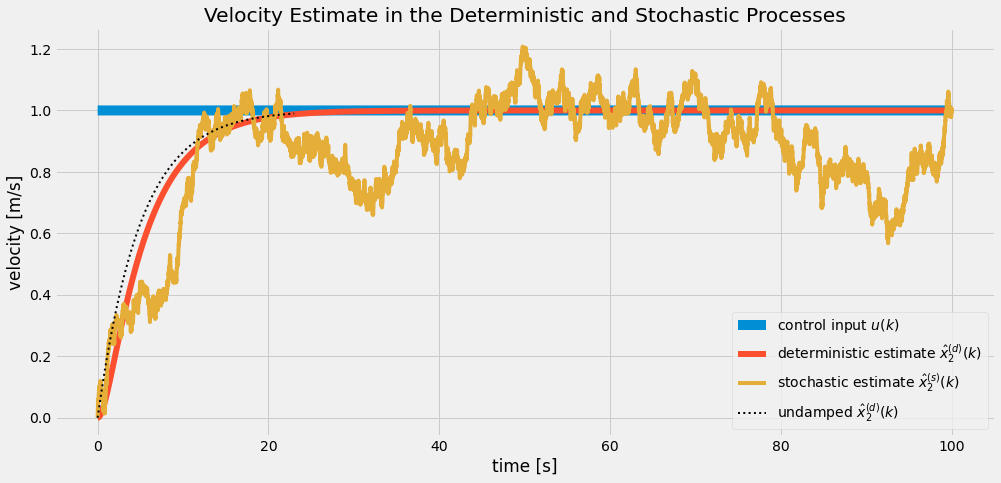

In [12]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=True, figsize=(15,7))

ax = axes
ax.set_title(r'Velocity Estimate in the Deterministic and Stochastic Processes')
ax.plot(t, u[2], lw=10)
ax.plot(t, xd[1], lw=6)
ax.plot(t, xs[1], lw=4)
ax.plot(t[(m:=(x:=1-np.exp(-t/T2))<.99)], x[m], lw=2, ls=':', color='0')
ax.legend([r'control input $u(k)$', r'deterministic estimate $\hat{x}_2^{(d)}(k)$', r'stochastic estimate $\hat{x}_2^{(s)}(k)$', r'undamped $\hat{x}_2^{(d)}(k)$'])
ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [m/s]')
plt.show()

# 4 Optimal Kalman Filter

We will now implement the discrete Kalman filter for the cart model. The discrete Kalman filter is an algorithm running in a loop, updating an a-priori estimate of the state $\bar{\mathbf{x}}_k$ with an a-posteriori estimate $\hat{\mathbf{x}}_k$ after taking the noisy measurement $\mathbf{z}_k$ into account. Depending on the statistics of the system and measurement, we assign a certain weight to the measurement, such that the updated estimate becomes
$$
\hat{\mathbf{x}}_k = \bar{\mathbf{x}}_k + \mathbf{K}_k (\mathbf{z}_k - \mathbf{H}\bar{\mathbf{x}}_k).
$$
The weight $\mathbf{K}_k$ is the Kalman gain, which we seek to optimize such that it minimizes the expected state estimate error $\hat{\mathbf{e}}_k = \mathbf{x}_k - \hat{\mathbf{x}}_k$ in the minimum-variance sense. The general formulation for error variance is given by the covariance matrix;
$$
\hat{\mathbf{P}}_k = \mathbb{E} \big[ \hat{\mathbf{e}}_k \hat{\mathbf{e}}_k^T \big] = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \bar{\mathbf{P}}_k (\mathbf{I} - \mathbf{K}_k \mathbf{H})^T + \mathbf{K}_k \mathbf{R} \mathbf{K}_k^T
$$
where $\bar{\mathbf{P}}_k$ is the covariance matrix of the "a-priori" estimate error. To optimize the Kalman gain thus means that, at each time step $k$, we want to find ${\mathbf{K}_k}$ such that it minimizes $\mathrm{trace} \hspace{1pt} \hat{\mathbf{P}}_k$. More formally, we can write
$$
\mathrm{argmin}_{\mathbf{K}_k} \mathrm{trace} \hspace{1pt} \hat{\mathbf{P}}_k
\quad \Rightarrow \quad \frac{d(\mathrm{trace} \hspace{1pt} \hat{\mathbf{P}}_k)}{d {\mathbf{K}_k}} = 0.
$$
Solving this, we find the update equation for the optimal Kalman gain
$$ 
\mathbf{K}_k = \bar{\mathbf{P}}_k \mathbf{H}^T (\mathbf{H} \bar{\mathbf{P}}_k \mathbf{H}^T + \mathbf{R})^{-1}.
$$

Plugging the optimal $\mathbf{K}_k$ into the equation for $\hat{\mathbf{P}}_k$ above, we get the simpler formulation
$$
\hat{\mathbf{P}}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \bar{\mathbf{P}}_k.
$$
We then use $\hat{\mathbf{P}}_k$ to recursively calculate the next-step a-priori covariance as
$$
\bar{\mathbf{P}}_{k+1} = \mathbf{\Phi} \hat{\mathbf{P}}_k \mathbf{\Phi}^T + \mathbf{\Gamma} \mathbf{Q} \mathbf{\Gamma}^T
$$
before we repeat the process. We mention here that the Kalman gain and state error covariance can be calculated without actually taking any measurements of the process, as long as we know its (possibly varying) statistics. We will use this when we set up the error budget in part 6 further down, but, in our application here we will also take measurements. We use the deterministic system equation from part  2 above to give us the a-priori state estimate:
$$
\bar{\mathbf{x}}_{k+1} = \mathbf{\Phi} \hat{\mathbf{x}}_k + \mathbf{\Lambda} \mathbf{u}_k.
$$

**Kalman filter algorithm:** 

_Input_: Measurements $\mathbf{z}_k$; control input $\mathbf{u}_k$; initial state estimate $\mathbf{x}_0$ with covariance $\mathbf{P}_0$
1. Initialize state $\bar{\mathbf{x}}_0 = \mathbf{x}_0$, covariance $\bar{\mathbf{P}}_0 = \mathbf{P}_0$, time variable $k = 0$. Then;
2. Update Kalman gain: $\mathbf{K}_k \leftarrow \bar{\mathbf{P}}_k \mathbf{H}^T (\mathbf{H} \bar{\mathbf{P}}_k \mathbf{H}^T + \mathbf{R})^{-1}$
3. Update a-posteriori state estimate: $\hat{\mathbf{x}}_k \leftarrow \bar{\mathbf{x}}_k + \mathbf{K}_k (\mathbf{z}_k - \mathbf{H}\bar{\mathbf{x}}_k)$
4. Update a-posteriori estimate covariance: $\hat{\mathbf{P}}_k \leftarrow (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \bar{\mathbf{P}}_k$
5. Update a-priori state estimate: $\bar{\mathbf{x}}_{k+1} \leftarrow \mathbf{\Phi} \hat{\mathbf{x}}_k + \mathbf{\Lambda} \mathbf{u}_k$
6. Update a-priori estimate covariance: $\bar{\mathbf{P}}_{k+1} \leftarrow \mathbf{\Phi} \hat{\mathbf{P}}_k \mathbf{\Phi}^T + \mathbf{\Gamma} \mathbf{Q} \mathbf{\Gamma}^T$
7. Update time variable: $k \leftarrow k + 1$
8. Repeat from 2. while $k < K$


An implemenation of the Kalman filter algorithm which filters the measurements ```z``` with control input ```u``` follows below. The ```mi``` parameter, for measurement interval, lets us define a sample frequency for the process simulation. Note that this implementation could very easily have been made much more efficient by pre-calculating some of the matrix products, but we skip that for clarity.

In [13]:
def kalman_filter(z, u, Fi, La, Ga, P0, H, R, mi, N=None):
    '''
    Filters the measurements z taken at intervals mi through the Kalman filter defined by 
    Fi, La, Ga, with measurement parameters H with statistics R. Control input u and initial
    state estimate error covariance P0. N is the blinding matrix used in the suboptimal
    Kalman filter.
    
    Returns tuple (x_bar, x_hat, p_bar, p_hat)
    '''
        
    # System order and simulation length
    p, _ = Fi.shape
    _, nm = z.shape
    _, n = u.shape
    I = np.eye(p)
    if N is None:
        N = np.eye(p)
    
    # State vector estimates
    x_bar = np.zeros((p,n))  # a-priori
    x_hat = np.zeros((p,nm))  # a-posteriori

    # Error covariance matrices
    P_bar = np.zeros((n,p,p))  # a-priori
    P_bar[0] = P0
    P_hat = np.zeros((nm,p,p))  # a-posteriori
    
    # Run simulation
    for k in range(n-1):
        
        # Measurement update
        if k%mi == 0:
            km = k//mi
            
            # Compute Kalman gain
            Kk = P_bar[k]@H.T@inv(H@P_bar[k]@H.T + R)

            # Update a-posteriori estimate
            x_hat[:,km,np.newaxis] = x_bar[:,k,np.newaxis] + Kk@(N@z[:,km,np.newaxis] - H@x_bar[:,k,np.newaxis])
            P_hat[km] = (I - Kk@H)@P_bar[k]

        # Time update - update a-priori estimate
        x_bar[:,k+1,np.newaxis] = Fi@x_hat[:,km,np.newaxis] + La@u[:,k,np.newaxis]
        P_bar[k+1] = Fi@P_hat[km]@Fi.T + Ga@Ga.T
    
    # Extract diagonals
    p_bar = np.array([P_bar[:,i,i] for i in range(p)])
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return (x_bar, x_hat, p_bar, p_hat)


We will now filter measurements of the sochastic system simulation from part 3 above and see if the Kalman filter gives us a better state estimate than the measurements alone will give us. We ran the stochastic simulation with time step $\Delta t = 0.01$ second, but will take measurements only once per second. We set measurement interval parameter ```mi``` to 100, and sample ```xs``` in noise ```w```, which we keep in the variable ```z```:

In [14]:
# Measurement update
mi = 100
tm = np.arange(0, tf, dt*mi)
nm = tm.size

# Take measurements
xm = xs[:,:-1:mi]
_, nm = xm.shape
w = np.zeros((3,nm))
w[0] = np.random.randn(nm)
z = H@xm + w

If we would rely only on measurements without taking any noise statistics into consideration, we would get the naive state estimates
$$
\begin{aligned}
\check{x}_1(t_k) &= z_1(t_k) \\
\check{x}_2(t_k) &= \frac{\check{x}_1(t_k) - \check{x}_1(t_k - \Delta t)}{\Delta t} \\
\check{x}_3(t_k) &= \check{x}_3(t_k - \Delta t) + \big( 1 - e^{-\Delta t/T_3} \big) \big( u_3(t_k) - \check{x}_3(t_k - \Delta t) \big)
\end{aligned},
$$
which can see plotted together with the repective true state variable below. We see that the direct measurement give estimates which are _far_ from the true values, especially for velocity. We will see next how the Kalman filter can help us achieve better results than these.

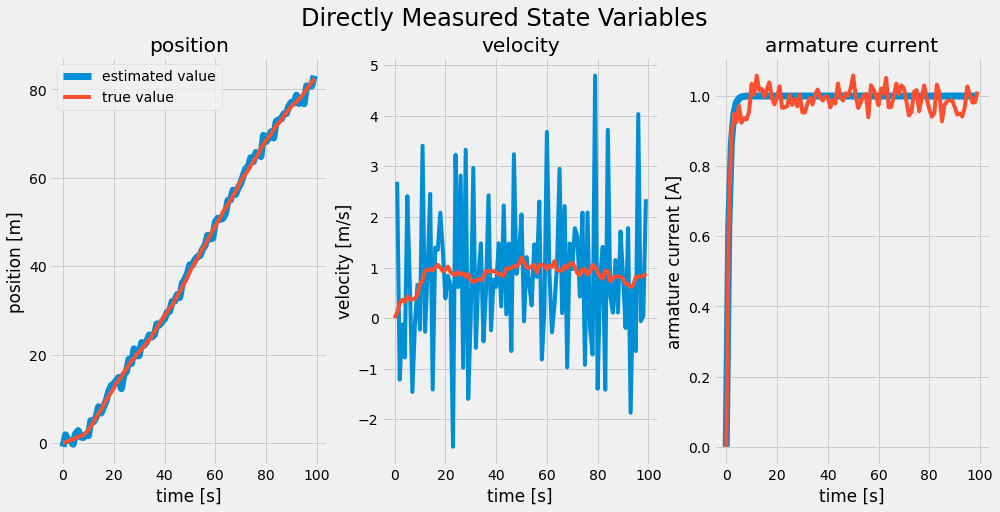

In [15]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=False, figsize=(15,7))
fig.suptitle(r'Directly Measured State Variables', fontsize=24)

ax = axes[0]
ax.set_title(r'position')
ax.plot(tm, z[0], lw=7)
ax.plot(tm, xm[0])
ax.legend(['estimated value', 'true value'])
ax.set_ylabel('position [m]')
ax.set_xlabel('time [s]')

ax = axes[1]
ax.set_title(r'velocity')
ax.plot(tm[1:], z[0,1:]-z[0,:-1])
ax.plot(tm, xm[1])
ax.set_ylabel('velocity [m/s]')
ax.set_xlabel('time [s]')
           
ax = axes[2]
ax.set_title(r'armature current')
x3 = np.zeros(nm)
for k in range(1,nm):
    x3[k] = x3[k-1] + (1-np.exp(-mi*dt/T3))*(1 - x3[k-1])
ax.plot(tm, x3, lw=7)
ax.plot(tm, xm[2])
ax.set_ylabel('armature current [A]')
ax.set_xlabel('time [s]')

plt.show()

For the Kalman filter, we must calculate a new set of discrete system matrices to account for relative time step between measurements, ```mi```.

In [16]:
# Kalman filter matrices
FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)

Then we filter the measurements...

In [17]:
# Run simulation
(x_bar, x_hat, p_bar, p_hat) = kalman_filter(z, u, FiK, LaK, GaK, P0, H, R, mi)
e_bar = xs - x_bar  # a-priori estimate error
e_hat = xm - x_hat  # a-posteriori estimate error

... and plot once more the estimated states $\hat{x}_i$ together with the true values, as we did above. We see that the Kalman filter _greatly_ improves the quality of the estimates, especially for the velocity, but also for position, which above would be up to a few meters off, but now overlaps almost perfectly with the true position. Armature current is more or less the same.

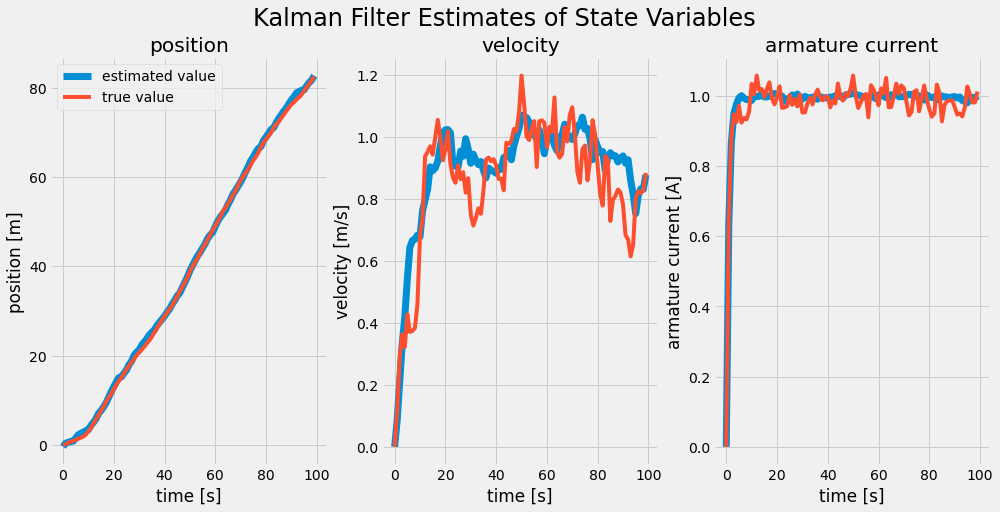

In [18]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=False, figsize=(15,7))
fig.suptitle(r'Kalman Filter Estimates of State Variables', fontsize=24)

ax = axes[0]
ax.set_title(r'position')
ax.plot(tm, x_hat[0], lw=7)
ax.plot(tm, xm[0])
ax.legend([r'estimated value', 'true value'])
ax.set_ylabel('position [m]')
ax.set_xlabel('time [s]')

ax = axes[1]
ax.set_title(r'velocity')
ax.plot(tm, x_hat[1], lw=7)
ax.plot(tm, xm[1])
ax.set_ylabel('velocity [m/s]')
ax.set_xlabel('time [s]')
           
ax = axes[2]
ax.set_title(r'armature current')
ax.plot(tm, x_hat[2], lw=7)
ax.plot(tm, xm[2])

ax.set_ylabel('armature current [A]')
ax.set_xlabel('time [s]')

plt.show()

Below, in the first plot, we see a-priori and a-posteriori estimates for velocity together with the true velocity and control input. We saw in the deterministic simulation that the control input $u$ translates 1-to-1 to velocity setpoint, but that the noise will cause it to miss that target. In the general case, the a-posteriori estimate should be better than the a-priori estimate, but from the curves in the first plot that conclusion cannot be drawn easily. Better then to look at the estimate errors, which are presented in the next plots. To that end, we define the errors
$$
\begin{aligned}
\bar{e}_2(k) &= x_2(k) - \bar{x}_2(k) \\
\hat{e}_2(k) &= x_2(k) - \hat{x}_2(k)
\end{aligned}
$$

In the plots, we see that both estimates do not deviate too much beyond the first standard deviation, and in the last plot we also see that there is a slight improvement from a-priori to a-posteriori.

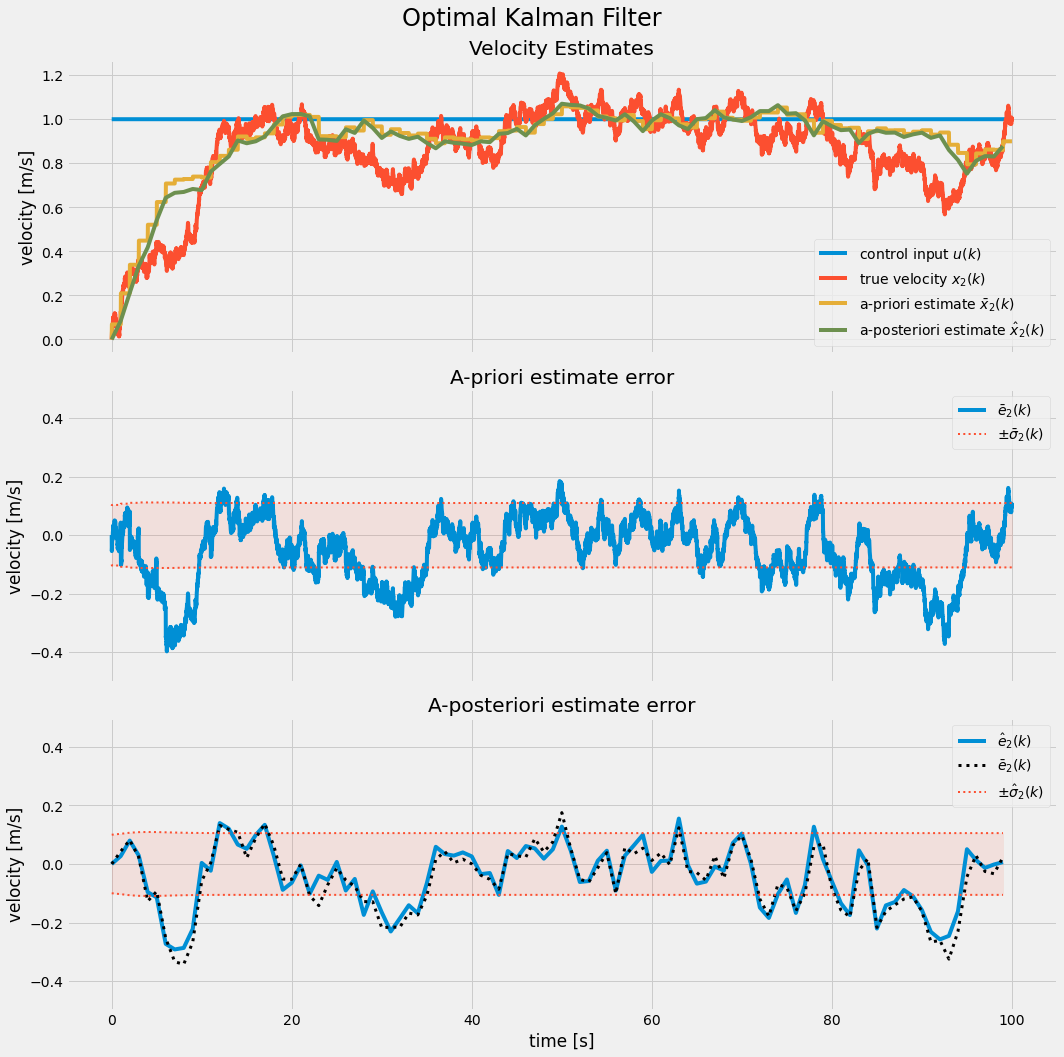

In [19]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=False, figsize=(15,15))
fig.suptitle(r'Optimal Kalman Filter', fontsize=24)

ax = axes[0]
ax.set_title('Velocity Estimates')
ax.plot(t, u[2])
ax.plot(t, xs[1])
ax.plot(t, x_bar[1])
ax.plot(tm, x_hat[1])
ax.legend([r'control input $u(k)$', r'true velocity $x_2(k)$', r'a-priori estimate $\bar{x}_2(k)$', r'a-posteriori estimate $\hat{x}_2(k)$'])
ax.set_ylabel('velocity [m/s]')

ax = axes[1]
ax.set_title('A-priori estimate error')
ax.plot(t, e_bar[1])
ax.plot(t, sqrt(p_bar[1]), color=COLORS[1], lw=2, ls=':')
ax.plot(t, -sqrt(p_bar[1]), color=COLORS[1], lw=2, ls=':')
ax.fill_between(t, sqrt(p_bar[1]), -sqrt(p_bar[1]), color=COLORS[1], alpha=.1)
ax.set_ylim((-.5,.5))
ax.legend([r'$\bar{e}_2(k)$', r'$\pm \bar{\sigma}_2(k)$'], loc='upper right')
ax.set_ylabel('velocity [m/s]')

ax = axes[2]
ax.set_title('A-posteriori estimate error')
ax.plot(tm, e_hat[1], color=COLORS[0])
ax.plot(tm, e_bar[1,:-1:mi], color='0', lw=3, ls=':')
ax.plot(tm, sqrt(p_hat[1]), color=COLORS[1], lw=2, ls=':')
ax.plot(tm, -sqrt(p_hat[1]), color=COLORS[1], lw=2, ls=':')
ax.fill_between(tm, sqrt(p_hat[1]), -sqrt(p_hat[1]), color=COLORS[1], alpha=.1)
ax.set_ylim((-.5,.5))
ax.legend([r'$\hat{e}_2(k)$', r'$\bar{e}_2(k)$', r'$\pm \hat{\sigma}_2(k)$'], loc='upper right')
ax.set_ylabel('velocity [m/s]')
ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

Below we see that the error reduction in the a-posteriori estimate is stronger for position and velocity than it is for armature current. This also fits well with what we saw when we compared the direct estimates with the Kalman filter estimates.

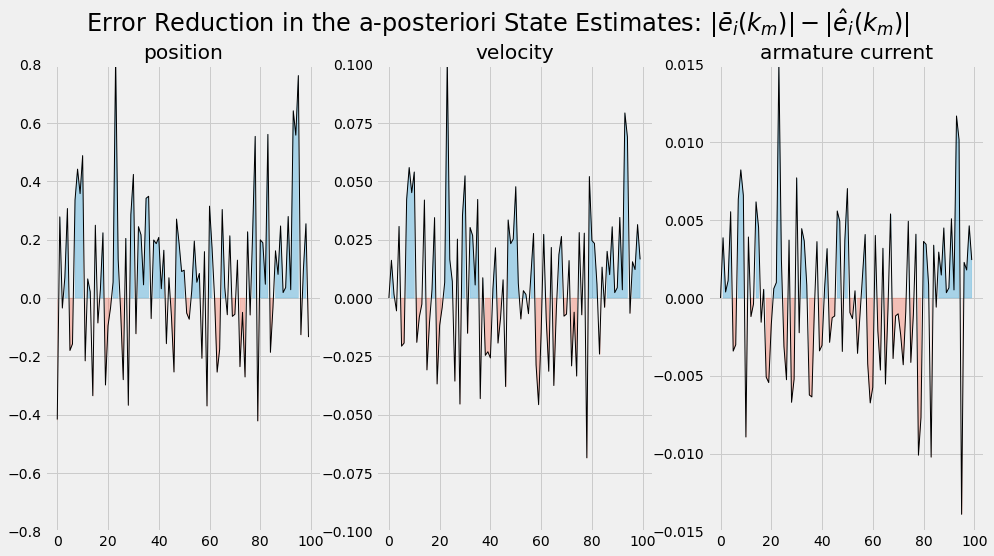

In [20]:
fig, axes = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=False, figsize=(15,8))
fig.suptitle(r'Error Reduction in the a-posteriori State Estimates: $|\bar{e}_i(k_m)| - |\hat{e}_i(k_m)|$', fontsize=24)

titles = ('position', 'velocity', 'armature current')
e_diff = np.abs(e_bar[:,:-1:mi]) - np.abs(e_hat)
zero_line = np.zeros(e_diff.shape[1])

for i, title in enumerate(titles):
    ax = axes[i]
    ax.set_title(f'{title}')
    ax.plot(tm, e_diff[i], color='0', lw=1)
    ax.fill_between(tm, zero_line, e_diff[i], where=e_diff[i]>0, color=COLORS[0], alpha=.3)
    ax.fill_between(tm, zero_line, e_diff[i], where=e_diff[i]<0, color=COLORS[1], alpha=.3)
    
axes[0].set_ylim(-.8,.8)
axes[1].set_ylim(-.1,.1)
axes[2].set_ylim(-.015,.015)
plt.show()

Another feature of the Kalman filter which gives us an indication in the a-posteriori improvement is the update equiation for the a-posteriori covariance matrix, which should result in a reduction of error variance -- that is;
$$
\hat{\mathbf{P}}_k = (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \bar{\mathbf{P}}_k \quad \Rightarrow \quad || \hat{\mathbf{P}}_k || < || \bar{\mathbf{P}}_k ||
$$
Below we see the error improvement statistics for our system, which also serves as a sanity check on our system model and implementation of the Kalman filter.

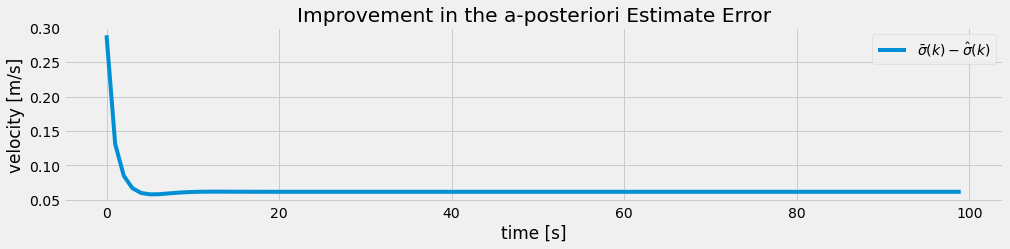

In [21]:
fig, axes = plt.subplots(ncols=1, nrows=1, figsize=(15,3))

ax = axes
ax.set_title('Improvement in the a-posteriori Estimate Error')
ax.plot(tm, sqrt(p_bar[:,:-1:mi].sum(axis=0)) - sqrt(p_hat.sum(axis=0)))
ax.set_ylabel('velocity [m/s]')
ax.set_xlabel('time [s]')
ax.legend([r'$\bar{\sigma}(k) - \hat{\sigma}(k)$'])
plt.show()

# 5 Monte Carlo simulation of optimal system

We will use Monte Carlo simulation to estimate the Kalman filter statistics for the velocity estimate;
$$
\begin{aligned}
\mathbb{E}[\hat{e}_2(k)] &\approx \hat{m}_2(k) = \frac{1}{N} \sum_{j=1}^N \hat{e}_2^{(j)}(k)  \\
\mathbb{E}[\hat{e}_2^2(k)] &\approx \hat{p}_2(k) = \frac{1}{N} \sum_{j=1}^N \big( \hat{e}_2^{(j)}(k) - \hat{m}_2(k) \big)^2 \\
\end{aligned}
$$
To do this, we must repeat the all non-deterministic steps performed in parts 3 and 4 for each run $j = 1,2,...,N$ -- that is;
1. Simulate the stochastic process to resample the process noise $v$
2. Take new measurements of the process to resample measurement noise $w$
3. Repeat until done

An implementation which lets us select the number of runs ```N``` follows below.

In [22]:
# Kalman filter model matrices
FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)

# Stochastic system model matrices
FiS, LaS, GaS = c2d_stochastic(F, L, G, Q, dt)

In [23]:
def monte_carlo(N):
    '''Runs Monte Carlo simulation with N runs.'''

    # Run simulations
    X_bar, X_hat, E_bar, E_hat = list(), list(), list(), list()
    for i in tqdm(range(N)):
        # New stochasitic process simulation
        v = np.zeros((3,n))
        v[2] = np.random.randn(n)
        xs = run_stochastic(u, v, FiS, LaS, GaS)

        # Take measurements
        xm = xs[:,:-1:mi]
        w = np.zeros((3,nm))
        w[0] = np.random.randn(nm)
        z = H@xm + w

        # Run Kalman filter simulation
        (x_bar, x_hat, p_bar, p_hat) = kalman_filter(z, u, FiK, LaK, GaK, P0, H, R, mi)
        X_bar.append(x_bar)
        X_hat.append(x_hat)
        E_bar.append(xs-x_bar)
        E_hat.append(xm-x_hat)

    X_bar = np.concatenate(X_bar).reshape(N,3,-1)
    X_hat = np.concatenate(X_hat).reshape(N,3,-1)
    E_bar = np.concatenate(E_bar).reshape(N,3,-1)
    E_hat = np.concatenate(E_hat).reshape(N,3,-1)
    
    return (X_bar, X_hat, E_bar, E_hat, p_bar, p_hat)

We begin with $N=10$ runs. In the first plots below we see the a-priori and a-posteriori **velocity estimates** for each run. The a-priori estimate is constant between each measurement update, since we do not change $u$, but keep it constant throughout the simulation. It therefore gets the _staricase_-like trajectory that we see to the left below. Both estimates mainly keep within the 0.8 to 1.2 m/s range after about 20 seconds. The **errors** are seen further down, plottet together with the respective error standard deviation. In the a-priori case, the error is calculated for each time step in the stochastic simulation, and therefore _looks_ more noisy than the a-posteriori error, but their _variances_ do not differ very much.

In [24]:
(X_bar, X_hat, E_bar, E_hat, p_bar, p_hat) = monte_carlo(10)

100%|██████████| 10/10 [00:01<00:00,  5.49it/s]


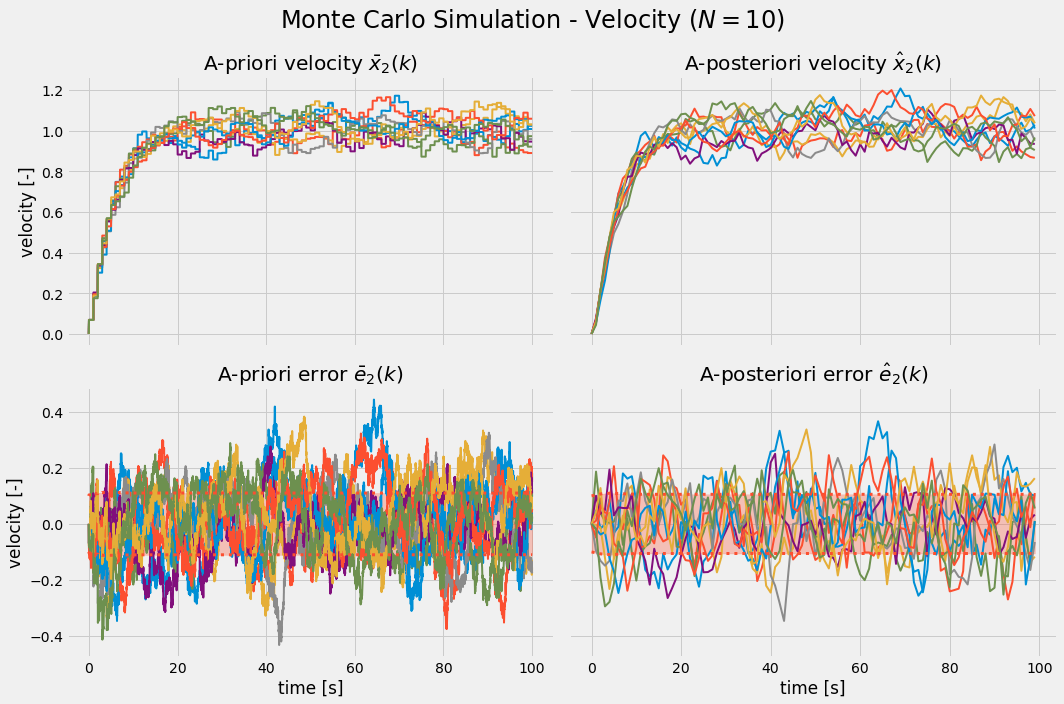

In [25]:
fig, axes = plt.subplots(ncols=2, nrows=2, sharex='col', sharey='row', figsize=(15,10))
fig.suptitle(r'Monte Carlo Simulation - Velocity ($N=10$)', fontsize=24)

ax = axes[0,0]
ax.set_title(r'A-priori velocity $\bar{x}_2(k)$')
ax.plot(t, X_bar[:,1,:].T, lw=2)
ax.set_ylabel('velocity [-]')

ax = axes[0,1]
ax.set_title(r'A-posteriori velocity $\hat{x}_2(k)$')
ax.plot(tm, X_hat[:,1,:].T, lw=2)

ax = axes[1,0]
ax.set_title(r'A-priori error $\bar{e}_2(k)$')
ax.plot(t, E_bar[:,1,:].T, lw=2)
ax.plot(t, sqrt(p_bar[1]), color=COLORS[1], lw=3, ls=':')
ax.plot(t, -sqrt(p_bar[1]), color=COLORS[1], lw=3, ls=':')
ax.fill_between(t, sqrt(p_bar[1]), -sqrt(p_bar[1]), color=COLORS[1], alpha=.3)
ax.set_ylabel('velocity [-]')
ax.set_xlabel('time [s]')

ax = axes[1,1]
ax.set_title(r'A-posteriori error $\hat{e}_2(k)$')
ax.plot(tm, E_hat[:,1,:].T, lw=2)
ax.plot(tm, sqrt(p_hat[1]), color=COLORS[1], lw=3, ls=':')
ax.plot(tm, -sqrt(p_hat[1]), color=COLORS[1], lw=3, ls=':')
ax.fill_between(tm, sqrt(p_hat[1]), -sqrt(p_hat[1]), color=COLORS[1], alpha=.3)
ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

Then, let's look at the statistics. Below we see the calculated error mean $\hat{m}$ and standard deviation $\hat{p}_2^{1/2}$ together with the true Kalman filter standard deviation for $N=10, 100$ and $1000$. We see that as $N$ increases, the mean approaches zero, as expected, and that the Monte Carlo standard deviation places itself slightly above the Kalman filter value. This is also to expect (_Gelb_ p. 261 _"[...] filter covariance calculations are generally an optimistic indication of the accuracy of the filter."_).

100%|██████████| 1000/1000 [03:11<00:00,  5.23it/s]


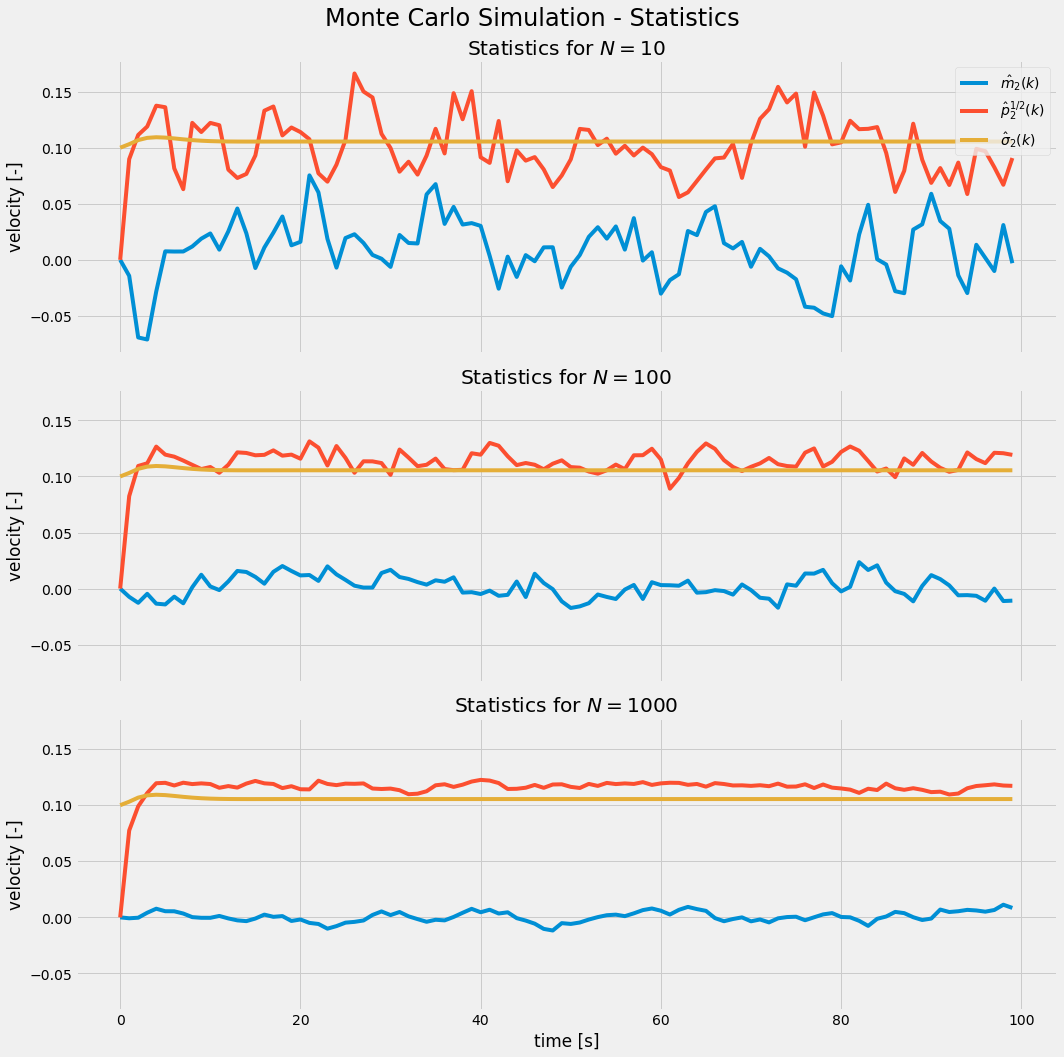

In [26]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex=True, sharey=True, figsize=(15,15))
fig.suptitle(r'Monte Carlo Simulation - Statistics', fontsize=24)

j = 1  # pick variable to plot
for i, N in enumerate((10,100,1000)):
    (X_bar, X_hat, E_bar, E_hat, p_bar, p_hat) = monte_carlo(N)
    ax = axes[i]
    ax.set_title(fr'Statistics for $N={{{N}}}$')
    ax.plot(tm, E_hat[:,j,:].mean(axis=0))
    ax.plot(tm, E_hat[:,j,:].std(axis=0))
    ax.plot(tm, sqrt(p_hat[j]))
    ax.set_ylabel('velocity [-]')

    if i == 0:
        ax.legend([r'$\hat{m}_2(k)$', r'$\hat{p}_2^{1/2}(k)$', r'$\hat{\sigma}_2(k)$'], loc='upper right')

ax.set_xlabel('time [s]')

fig.tight_layout()
plt.show()

# 6 Error budget for optimal Kalman filter

We will now investigate how the different stochastic factors affect the error covariance in the Kalman filter. We have three sources of error, and these are
1. The initial covariance estimate $\mathbf{P}_0$
2. The process noise $\mathbf{v}(t) \sim \mathcal{N}(\mathbf{0}, \tilde{\mathbf{Q}} \delta(t-\tau))$
3. The measurement noise $\mathbf{w}_k \sim \mathcal{N}(\mathbf{0}, \tilde{\mathbf{R}} \delta_{kl})$

Since we are not modeling an observed physical system the system model is quite simple, and the system and filter models are equal (including the noise model). We can therefore set up the error budget using the following simplified equations:
$$
\begin{aligned}
\bar{\mathbf{P}}_0 &= \mathbf{P}_0 \\
\hat{\mathbf{P}}_k &= (\mathbf{I} - \mathbf{K}_k \mathbf{H}) \bar{\mathbf{P}}_k (\mathbf{I} - \mathbf{K}_k \mathbf{H})^T + \mathbf{K}_k \mathbf{R} \mathbf{K}_k^T \\
\bar{\mathbf{P}}_{k+1} &= \mathbf{\Phi} \hat{\mathbf{P}}_k \mathbf{\Phi}^T + \mathbf{\Gamma} \mathbf{Q} \mathbf{\Gamma}^T
\end{aligned}
$$
We see that the update equation for $\hat{\mathbf{P}}$ has been changed from the one we saw in the optimal Kalman filter earlier. The reason for that is that we will use the Kalman gain from the optimal filter, which has all stochastic factors intact, while we blind out the contribution from all but one stochastic factor in a consecutive manner when we calculate the error budget. In our system, we have five different stochastic factors;
* The three individual contributions form the diagonals elements in $\mathbf{P}_0$, which we denote $\sigma_{pos}^2, \sigma_{vel}^2, \sigma_{curr}^2$
* The process noice contribution to armature current, denoted $\sigma_{proc}^2$
* The noice contribution to the position measurement, denoted $\sigma_{meas}^2$

As said, we will consecutively blind out the contributions from all but one source. This lets us extract the contribution from the individual error sources on the individual state estimates. In sum, each state estimate error then has the standard deviation
$$
\hat{\sigma}_{sum} = \sqrt{\sigma_{pos}^2 + \sigma_{vel}^2 + \sigma_{curr}^2 + \sigma_{proc}^2 + \sigma_{meas}^2}.
$$
Since $\mathbf{P}_0, \tilde{\mathbf{Q}}$ and $\mathbf{R}$ do not affect the calculation of $\mathbf{\Phi}$, and since the process noise has a contribution in only one state variable, we do not have to re-calculate the discrete system equations when we blind out the stochastic factors.


Before we move on to the calculations, we make a function which lets us pre-calculate the Kalman gain for the error budgets using a simplified set of measurement-free Kalman filter equations:
$$
\begin{aligned}
\bar{\mathbf{P}}_0 &= \mathbf{P}_0 \\
\hat{\mathbf{P}}_k &= (\bar{\mathbf{P}}_k + \mathbf{H}^T \mathbf{RH})^{-1} \\
\bar{\mathbf{P}}_{k+1} &= \mathbf{\Phi} \hat{\mathbf{P}}_k \mathbf{\Phi}^T + \mathbf{\Gamma} \mathbf{Q} \mathbf{\Gamma}^T
\end{aligned}.
$$

In [27]:
def kalman_gains(Fi, Ga, P0, H, R, n):
    '''
    Measurement-free calculation of Kalman gain for system described by Fi, Ga, P0, 
    with measurement characteristics H, R.
    '''
    # Model order
    p, _ = Fi.shape

    # A-posteriori error covariance matrix
    P_hat = np.zeros((n,p,p))

    # Kalman gains
    K = np.zeros((n,p,p))
    
    P_bar = P0
    for k in range(n):
        # Update a-posteriori estimate
        P_hat[k] = inv(inv(P_bar) + H.T@R@H)
        K[k] = P_hat[k]@H.T@inv(R)
        
        # Update a-priori estimate
        P_bar = Fi@P_hat[k]@Fi.T + Ga@Ga.T
        
    # Extract diagonals
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return (K, p_hat)

Then, let's implement a function which lets us calculate the blinded-out covariences:

In [28]:
def covar_analysis(Fi, Ga, P0, H, R, K):
    '''
    Calculates the error covariance of the system described by Fi, Ga, P0,
    with measurement characteristics R, H by applying Kalman gains K.
    '''
    # Model order and calculation range
    n, p, _ = K.shape
    I = np.eye(p)

    # A-posteriori error covariance matrix
    P_hat = np.zeros((n,p,p))
    
    P_bar = P0
    for k in range(n):
        # Update a-posteriori
        P_hat[k] = (I - K[k]@H)@P_bar@(I - K[k]@H).T + K[k]@R@K[k].T

        # Update a-priori
        P_bar = Fi@P_hat[k]@Fi.T + Ga@Ga.T
        
    # Extract diagonals
    p_hat = np.array([P_hat[:,i,i] for i in range(p)])
    
    return p_hat

We begin the error budget calculations by calculating the Kalman gain over ```nm``` iterations, and keep at the same time the diagonal elements of the total estimation error covariance matrix, ```p_tot```. We will use this to evaluate the sum of the individial contributions, ```p_sum```, calculated further down.

In [29]:
# Calculate Kalman gains and the total estimation error covariance
FiK, LaK, GaK = c2d_stochastic(F, L, G, Q, dt*mi)
K, p_tot = kalman_gains(FiK, GaK, P0, H, R, nm)

Then we calculate the individual error covariance contributions which make up the error budget for our system:

In [30]:
# Error budget calculation

# P0 position
P0e = P0*np.array([[1],[0],[0]])
Gae = GaK*0
Re = R*0
p_P0_pos = covar_analysis(FiK, Gae, P0e, H, Re, K)

# P0 velocity
P0e = P0*np.array([[0],[1],[0]])
p_P0_vel = covar_analysis(FiK, Gae, P0e, H, Re, K)

# P0 armature current
P0e = P0*np.array([[0],[0],[1]])
p_P0_cur = covar_analysis(FiK, Gae, P0e, H, Re, K)

# Process noise
P0e = P0*0
Gae = GaK*1
Re = R*0
p_proc = covar_analysis(FiK, Gae, P0e, H, Re, K)

# Measurement noise
Gae = GaK*0
Re = R*1
p_meas = covar_analysis(FiK, Gae, P0e, H, Re, K)

We do some data structuring and plot the results below.

When we look at the plots, the most immediate insight is that the effect of the **initial covariance estimate** $\mathbf{P}_0$ is of course strongest in the state correspoding to the respective state variable. It also dies out within 20 seconds, meaning that it is not a hugely critical parameter for the performance of the Kalman filter in the application which we study here. The next insight is that for **position**, it is the measurement noise which is most important, while the process noise, to which it is only indirectly linked, is less influential. For **velocity** and **armature current**, the process noise is completely dominating. In the design of a system, this would tell us that our effort should go into better regulation of the DC power source than a less noisy position measurement sensor, if we want an accurate speed estimate.

Especially armature current is very weakly affected by the noise in the position measurements, which is not surprising given that the connection between armature current and position is strictly one-way in the system equations. However, the _estimate_ of position also affects armature current, and that is why we see a small flow of uncertainty from position measurement noise back to the armature current estimate.

In [31]:
# Structuring error budget results
p_collection = [p_P0_pos, p_P0_vel, p_P0_cur, p_proc, p_meas]
p_sum = np.concatenate(p_collection).reshape(5,3,-1).sum(axis=0)
p_collection = [p_sum] + p_collection

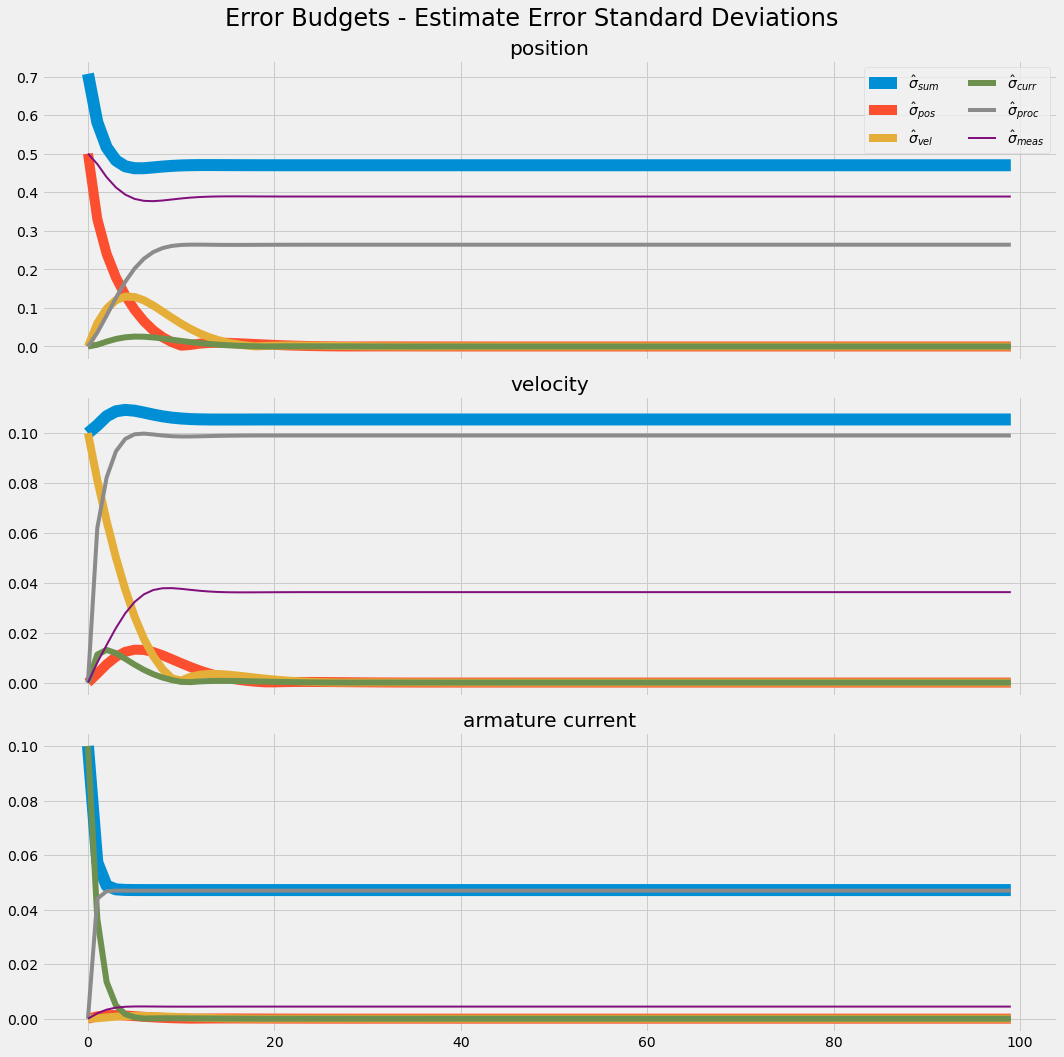

In [32]:
fig, axes = plt.subplots(ncols=1, nrows=3, sharex='col', sharey='row', figsize=(15,15))
fig.suptitle(r'Error Budgets - Estimate Error Standard Deviations', fontsize=24)

titles = ('position', 'velocity', 'armature current')
labels = (r'$\hat{\sigma}_{sum}$', r'$\hat{\sigma}_{pos}$', r'$\hat{\sigma}_{vel}$', r'$\hat{\sigma}_{curr}$', r'$\hat{\sigma}_{proc}$', r'$\hat{\sigma}_{meas}$')

for i, title in enumerate(titles):
    ax = axes[i]
    ax.set_title(rf'{title}')
    for j, arr in enumerate(p_collection):
        ax.plot(tm, sqrt(arr[i]), lw=12-2*j)
    if i == 0:
        ax.legend(labels, ncol=2)

fig.tight_layout()
plt.show()

Finally, we confirm by inspecting the plot below that the sum of the individual contributions to the error add up to the error which we get by including all error sources;
$$
\hat{\sigma}_{sum} = \hat{\sigma}_{tot}.
$$
They are, as we see, overlapping each other completely.

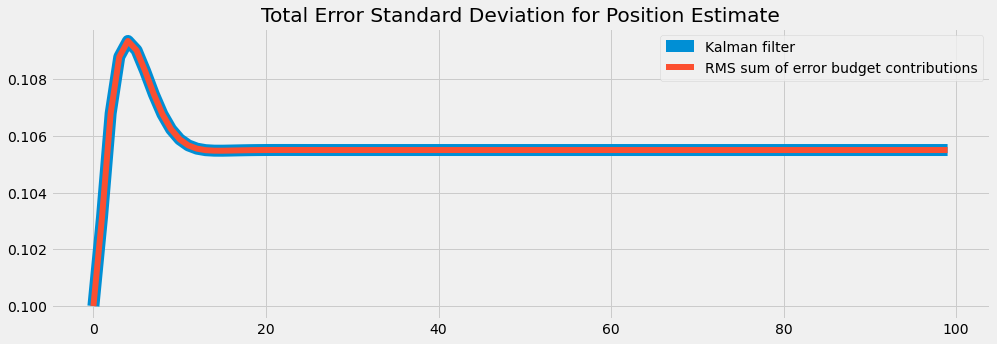

In [33]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex='col', sharey='row', figsize=(15,5))

ax = axes
ax.set_title(r'Total Error Standard Deviation for Position Estimate')
ax.plot(tm, sqrt(p_tot[1]), lw=12)
ax.plot(tm, sqrt(p_sum[1]), lw=6)
ax.legend((r'Kalman filter', r'RMS sum of error budget contributions'))
plt.show()

# 7 Suboptimal Kalman filter

At last, we will look at how the Kalman filter performs when we use a reduced model of the system as basis. This reduced model, or _filter model_ $\mathcal{M^F}$, will treat the armature current $x_3$ as white noise, such that we get the filter model state vector
$$
\mathbf{x}^* = \mathbf{N}\mathbf{x}
\quad \Rightarrow \quad 
\begin{bmatrix}
\dot{x}_1^* \\ \dot{x}_2^*
\end{bmatrix}
=
\begin{bmatrix}
1 & 0 & 0 \\
0 & 1 & 0
\end{bmatrix}
\begin{bmatrix}
x_1 \\ x_2 \\x_3
\end{bmatrix}
$$
Here, we have introduced a _blinding matrix_ $\mathbf{N}$, which _blinds out_ the all but the relevant states in the system model $\mathcal{M^S}$. For reasons which will become apparent later, we will wish to keep the shape of the input vector $\mathbf{u}$ unchanged, such that we get the filter model equation
$$
\dot{\mathbf{x}}^* = \mathbf{F}^* \mathbf{x}^* + \mathbf{L}^* \mathbf{u} + \mathbf{G}^* \mathbf{v}^*
\quad \Rightarrow \quad
\begin{bmatrix}
\dot{x}_1^* \\ \dot{x}_2^*
\end{bmatrix}
=
\begin{bmatrix}
0 & 1 \\
0 & \frac{-1}{T_2}
\end{bmatrix}
\begin{bmatrix}
x_1^* \\ x_2^*
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 & 0 \\
0 & 0 & \frac{1}{T_2}
\end{bmatrix}
\begin{bmatrix}
0 \\ 0 \\ u
\end{bmatrix}
+
\begin{bmatrix}
0 & 0 \\
0 & \frac{1}{T_2}
\end{bmatrix}
\begin{bmatrix}
0 \\ v^*
\end{bmatrix}.
$$
Here, $v^*$ is the random variable representing $x_3$ in the velocity equation -- hence the $\frac{1}{T_2}$ gain. Since we treat $x_3$ as white noise, $v^*$ must be a zero-mean Gaussian, but we do not yet know its variance. To find this, we will use the linear variance equation, which in the scalar case has takes the form
$$
\dot{p}_3(t) = 2f_3(t)p_3(t) + q_3(t).
$$
In our case, $f_3(t) = -\frac{1}{T_3}$ and $q_3(t) = \tilde{q}$, such that the equation becomes
$$
\dot{p}_3(t) = -\frac{2}{T_3} p_3(t) + \tilde{q},
$$
which has the steady-state solution
$$
\lim_{t \rightarrow \infty} p_3(t) = \frac{T_3}{2} \tilde{q}.
$$
Hence, for the reduced filter model we get the process noise
$$
v^*(t) \sim \mathcal{N} \big( 0, \frac{T_3}{2} \tilde{q} \delta(t - \tau) \big).
$$

We will first see how the suboptimal Kalman filter performs by studying the velocity estimate, and then perform a covariance analysis.

Let's start by declaring the two-state filter model variables:

In [34]:
# Filter model dimensions
pF, p = 2, 3
pa = pF + p
N = np.eye(pF+p)[:pF,:p]

# Filter model matrices
QF = T3/2*Q[:pF,:pF]
FF = np.array([[0, 1],
               [0, -1/T2]])
LF = np.array([[0, 0, 0],
               [0, 0, 1/T2]])
GF = np.array([[0, 0],
               [0, 1/T2]])
P0F = np.diag([1,.1**2])

# Measurement parameters
RF = 1*np.eye(2)
HF = np.array([[1, 0],
               [0, 0]])

Then we run a simulation using $\mathcal{M^S}$ and keep the results as before in a variable ```xs```:

In [35]:
# System model discrete matrices
FiS, LaS, GaS = c2d_stochastic(F, L, G, Q, dt)

# New stochasitic process simulation
v = np.zeros((3,n))
v[2] = np.random.randn(n)
xs = run_stochastic(u, v, FiS, LaS, GaS)

As for the optimal case, we use the system model measurement matrix $\mathbf{H}$, but, since we only model two states in the filter, we must apply the blinding matrix $\mathbf{N}$ in the Kalman filter at measurement update, such that the a-posteriori state estimate in the algorithm becomes
$$
\hat{\mathbf{x}}_k \leftarrow \bar{\mathbf{x}}_k + \mathbf{K}_k (\mathbf{Nz}_k - \mathbf{H}\bar{\mathbf{x}}_k).
$$
We thus take the measurements from the simulation...

In [36]:
# Take measurements
xm = xs[:,:-1:mi]
_, nm = xm.shape
w = np.zeros((3,nm))
w[0] = np.random.randn(nm)
z = H@xm + w

... and run them through the suboptimal Kalman filter, where we have applied the optional argument ```N=N``` to signal that this is the suboptimal case. Here we also see, for the first time, why we benefit from keeping the dimensionality of $\mathbf{u}$ unchanged between the optimal and suboptimal filters.

In [37]:
# Suboptimal Kalman filter
FiF, LaF, GaF = c2d_stochastic(FF, LF, GF, QF, dt*mi)
(x_bar_s, x_hat_s, p_bar_s, p_hat_s) = kalman_filter(z, u, FiF, LaF, GaF, P0F, HF, RF, mi, N=N)

For comparison, we also run the measurements through the optimal Kalman filter...

In [38]:
# Optimal Kalman filter
Fi, La, Ga = c2d_stochastic(F, L, G, Q, dt*mi)
(x_bar_o, x_hat_o, p_bar_o, p_hat_o) = kalman_filter(z, u, Fi, La, Ga, P0, H, R, mi, N=None)

... and plot the velocity estimates together with the true value.

We see that the suboptimal filter has a smoothing effect on the estimate, which is caused by the blinding-out of the armature current noise when we apply $\mathbf{N}$ on the a-priori state estimate -- that is;
$$
\bar{\mathbf{x}}_{k+1}^* \leftarrow \mathbf{\Phi}^* \mathbf{z}_k^* + \mathbf{\Lambda}^* \mathbf{u}_k =  \mathbf{\Phi}^* \mathbf{Nz}_k + \mathbf{\Lambda}^* \mathbf{u}_k.
$$
Below we see that the remaining elements in the filter model transition matrix ```FiF``` are identical to the corresponding system model matrix ```Fi```, which supports this conclusion.

In [39]:
FiF, Fi

(array([[1.        , 0.90634623],
        [0.        , 0.81873075]]),
 array([[1.        , 0.90634623, 0.06855642],
        [0.        , 0.81873075, 0.11271283],
        [0.        , 0.        , 0.36787944]]))

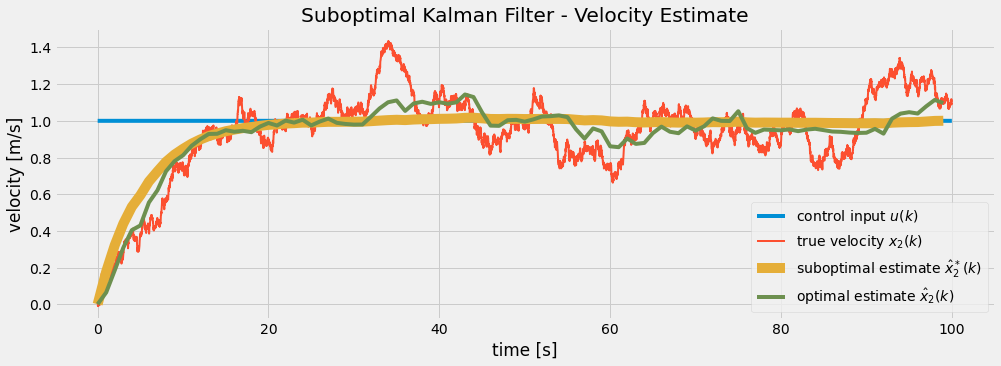

In [40]:
fig, axes = plt.subplots(ncols=1, nrows=1, sharex=True, sharey=False, figsize=(15,5))

ax = axes
ax.set_title(r'Suboptimal Kalman Filter - Velocity Estimate')
ax.plot(t, u[2])
ax.plot(t, xs[1], lw=2)
ax.plot(tm, x_hat_s[1], lw=10)
ax.plot(tm, x_hat_o[1])
ax.legend([r'control input $u(k)$', r'true velocity $x_2(k)$', r'suboptimal estimate $\hat{x}^*_2(k)$', r'optimal estimate $\hat{x}_2(k)$'])
ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [m/s]')

plt.show()

Since we remove some of the _observed_ process noise when we do the model reduction, we could perhaps be tempted to conclude that the suboptimal estimate is _better_, given that the estimate is smoother. And that might be the right conclusion, in some cases -- but, the cost of this smoothing is a somewhat larger error in the estimate, which we will investigate next by covariance analyis.

We cannot directly proceed as we did in part 6, by running the ```covar_analysis()``` function with the suboptimal matrices -- the resulting $\hat{\mathbf{P}}^*$ is unreliable. Instead, we will set up a system of augmented states, $\mathbf{x}^{(a)}$, which models suboptimal the errors as two of its states;
$$
\mathbf{x}^{(a)} = 
\begin{bmatrix}
\hat{\mathbf{e}}^* \\
\mathbf{x} \\
\end{bmatrix}
=
\begin{bmatrix}
\mathbf{Nx} - \hat{\mathbf{x}}^* \\
\mathbf{x} \\
\end{bmatrix}.
$$
To set up the corresponding augmented matrices, we begin with the a-priori estimate error, which becomes
$$
\bar{\mathbf{e}}_{k+1}^* = \mathbf{Nx}_{k+1} - \bar{\mathbf{x}}_{k+1}^* = \mathbf{N} (\mathbf{\Phi}\mathbf{x}_k + \mathbf{\Lambda}\mathbf{u}_k + \mathbf{\Gamma}\mathbf{v}_k) - (\mathbf{\Phi}^*\hat{\mathbf{x}}^*_k + \mathbf{\Lambda}^*\mathbf{u}_k).
$$
Here we see for the second time the benefit of keeping the dimensions of $\mathbf{u}$ unchanged between the system and filter models: We add a zero sum term $(\mathbf{\Phi}^*\mathbf{N}\mathbf{x}_k - \mathbf{\Phi}^*\mathbf{N}\mathbf{x}_k)$ and write
$$
\begin{aligned}
\bar{\mathbf{e}}_{k+1}^* &= \mathbf{\Phi}^*(\mathbf{N}\mathbf{x}_k - \hat{\mathbf{x}}^*_k) + (\mathbf{N \Lambda} - \mathbf{\Lambda}^*)\mathbf{u}_k + \mathbf{N \Gamma}\mathbf{v}_k + (\mathbf{N \Phi} - \mathbf{\Phi}^*\mathbf{N})\mathbf{x}_k \\
&= \mathbf{\Phi}^*\hat{\mathbf{e}}^*_k + \Delta \mathbf{\Lambda} \mathbf{u}_k + \mathbf{N \Gamma}\mathbf{v}_k + \Delta \mathbf{\Phi} \mathbf{x}_k.
\end{aligned}
$$
The augmented a-priori state equation thus becomes
$$
\bar{\mathbf{x}}^{(a)}_{k+1} = 
\begin{bmatrix}
\mathbf{\Phi}^* & \Delta \mathbf{\Phi} \\
\mathbf{0} & \mathbf{\Phi}
\end{bmatrix}
\hat{\mathbf{x}}^{(a)}_k
+
\begin{bmatrix}
\Delta \mathbf{\Lambda} \\ \mathbf{\Lambda}
\end{bmatrix}
\mathbf{u}_k
+
\begin{bmatrix}
\mathbf{N \Gamma} \\ \mathbf{\Gamma}
\end{bmatrix}
\mathbf{v}_k.
$$
Or, more consisely;
$$
\bar{\mathbf{x}}^{(a)}_{k+1} = \mathbf{\Phi}^{(a)} \hat{\mathbf{x}}^{(a)}_k + \mathbf{\Lambda}^{(a)} \mathbf{u}_k + \mathbf{\Gamma}^{(a)} \mathbf{v}_k.
$$

Likewise, we proceed to find the augmented measurement matrix and Kalman gain by expanding the a-posteriori estimate error;
$$
\hat{\mathbf{e}}_k^* = \mathbf{Nx}_k - \hat{\mathbf{x}}_k^* = \mathbf{Nx}_k - (\bar{\mathbf{x}}_k^* + \mathbf{K}_k^*(\mathbf{Nz}_k - \mathbf{H}^* \bar{\mathbf{x}}_k^*)).
$$
Again, we add a zero term $(\mathbf{H}^*\mathbf{N}\mathbf{x}_k - \mathbf{H}^*\mathbf{N}\mathbf{x}_k)$ inside the parenthesis, and expand $\mathbf{z}_k = \mathbf{Hx}_k + \mathbf{w}_k$. We then get
$$
\begin{aligned}
\hat{\mathbf{e}}_k^* &= \bar{\mathbf{e}}_k^* - \mathbf{K}_k^*(\mathbf{H}^* \bar{\mathbf{e}}_k^* + (\mathbf{NH} - \mathbf{H}^*\mathbf{N})\mathbf{x}_k + \mathbf{Nw}_k) \\
&= (\mathbf{I} - \mathbf{K}_k^*\mathbf{H}^*)\bar{\mathbf{e}}_k^* - \mathbf{K}_k^* \Delta \mathbf{H} \mathbf{x}_k - \mathbf{K}_k^* \mathbf{Nw}_k.
\end{aligned}
$$
For the augmented a-posteriori state, we thus get the equation
$$
\hat{\mathbf{x}}^{(a)}_k = 
\begin{bmatrix}
\mathbf{I}^* & \mathbf{0} \\
\mathbf{0} & \mathbf{I}
\end{bmatrix}
\bar{\mathbf{x}}^{(a)}_k
-
\begin{bmatrix}
\mathbf{K}_k^* \\ \mathbf{0}
\end{bmatrix}
\begin{bmatrix}
\mathbf{H}^* & \Delta \mathbf{H} \\
\end{bmatrix}
\bar{\mathbf{x}}^{(a)}_k
-
\begin{bmatrix}
\mathbf{K}_k^* \\ \mathbf{0}
\end{bmatrix}
\mathbf{Nw}_k,
$$
or, again, more consisely;
$$
\hat{\mathbf{x}}^{(a)}_k = (\mathbf{I}^{(a)} - \mathbf{K}_k^{(a)} \mathbf{H}^{(a)}) \bar{\mathbf{x}}^{(a)}_k - \mathbf{K}_k^{(a)} \mathbf{Nw}_k.
$$

Lastly, we must put the augmented covariance matrix into right shape. We apply the blinding matrix $\mathbf{N}$ appropriately and write directly
$$
\mathbf{P}^{(a)} = 
\begin{bmatrix}
\mathbf{NPN}^T & \mathbf{NP} \\
\mathbf{PN}^T & \mathbf{P}
\end{bmatrix}.
$$
The true error covariance $\mathbf{P}^{(e)}$ which we seek to find through the covariance analysis is then found in the upper left corner of $\mathbf{P}^{(a)}$;
$$
\mathbf{P}^{(a)}_k = 
\begin{bmatrix}
\mathbf{P}^{(e)}_k & \cdots \\
\cdots & \cdots
\end{bmatrix},
$$
and the variance of each state estimate error along $\mathbf{P}^{(e)}$'s diagonal.

Below, we implement first a function ```augmented_state()``` which transforms the state parameters into right shape, and then a function ```augmented_system()```, which transforms the system and filter matrices into the augmented system matrices:

In [41]:
def augmented_state(N, e, x, K, P0):
    pF, p = N.shape
    pa = pF + p
    n = K.shape[0]
    
    x_a = np.zeros((pa,n))
    x_a[:pF] = e
    x_a[pF:] = x
    
    K_a = np.zeros((n, pa, pF))
    K_a[:,:pF,:] = K
    
    P0_a = np.zeros((pa, pa))
    P0_a[:pF,:pF] = N@P0@N.T
    P0_a[:pF,pF:] = N@P0
    P0_a[pF:,:pF] = P0@N.T
    P0_a[pF:,pF:] = P0
    
    return (x_a, K_a, P0_a)

In [42]:
def augmented_system(N, Fi, FiF, La, LaF, Ga, GaF, H, HF):
    pF, p = N.shape
    pa = pF + p
    
    dFi = N@Fi - FiF@N
    dLa = N@La - LaF
    dH = N@H - HF@N
    
    Fi_a = np.zeros((pa, pa))
    Fi_a[:pF,:pF] = FiF
    Fi_a[:pF,pF:] = dFi
    Fi_a[pF:,pF:] = Fi
    
    La_a = np.zeros((pa, p))
    La_a[:pF] = dLa
    La_a[pF:] = La
    
    Ga_a = np.zeros((pa, p))
    Ga_a[:pF] = N@Ga
    Ga_a[pF:] = Ga
    
    H_a = np.zeros((pF, pa))
    H_a[:pF,:pF] = HF
    H_a[:pF,pF:] = dH
    
    return (Fi_a, La_a, Ga_a, H_a)

As we did in part 6, we can pre-calculate the Kalman gains to be used in the covariance analysis (we could also have used the last calculated gain as a fixed gain in the covariance analysis and get good results, but we do not do that here):

In [43]:
# Calculate Kalman gains using the filter model matrices
K, _ = kalman_gains(FiF, GaF, P0F, HF, RF, nm)

We calculate the augmented system paramteters...

In [44]:
(x_a, K_a, P0_a) = augmented_state(N, e_hat[:2], xm, K, P0)
(Fi_a, La_a, Ga_a, H_a) = augmented_system(N, Fi, FiF, La, LaF, Ga, GaF, H, HF)

... and run the analysis:

In [45]:
p_a = covar_analysis(Fi_a, Ga_a, P0_a, H_a, RF, K_a)

Before we plot the results, we also run a Monte Carlo simulation, to measure the results against the _ground truth_:

In [46]:
# Monte Carlo of suboptimal Kalman filter
runs = 1000
X_bar, X_hat, E_bar, E_hat = list(), list(), list(), list()
for i in tqdm(range(runs)):
    # New stochasitic process simulation
    v = np.zeros((3,n))
    v[2] = np.random.randn(n)
    xs = run_stochastic(u, v, FiS, LaS, GaS)

    # Take measurements
    xm = xs[:,:-1:mi]
    w = np.zeros((3,nm))
    w[0] = np.random.randn(nm)
    z = H@xm + w

    # Kalman filter
    (x_bar, x_hat, p_bar, p_hat) = kalman_filter(z, u, FiF, LaF, GaF, P0F, HF, RF, mi, N=N)
    X_bar.append(x_bar)
    X_hat.append(x_hat)
    E_bar.append(xs[:2]-x_bar)
    E_hat.append(xm[:2]-x_hat)

X_bar = np.concatenate(X_bar).reshape(runs,2,-1)
X_hat = np.concatenate(X_hat).reshape(runs,2,-1)
E_bar = np.concatenate(E_bar).reshape(runs,2,-1)
E_hat = np.concatenate(E_hat).reshape(runs,2,-1)

100%|██████████| 1000/1000 [03:09<00:00,  5.29it/s]


We see the results below. The general conclusions are that the covariance analysis results for the suboptimal Kalman filter cannot be trusted; the standard deviations $\hat{\sigma}_1^{*}, \hat{\sigma}_2^{*}$ are even lower than the optimal, which corresponds neither to what we saw above, nor to what we would expect. Further, we see that the  _true_ position result $\hat{\sigma}_1^{(e)}$ lies quite a bit above the optimal, $\hat{\sigma}_1^{(o)}$, while the Monte Carlo result standard deviation, $\hat{p}_1^{1/2}$, follows a similar trajectory as $\hat{\sigma}_1^{(e)}$, but with a gap. We see a similar, but maller, gap between the true and Monte Carlo results for velocity, as well. This corresponds to what we found for the Monte Carlo simulation of the optimal Kalman filter in part 5.

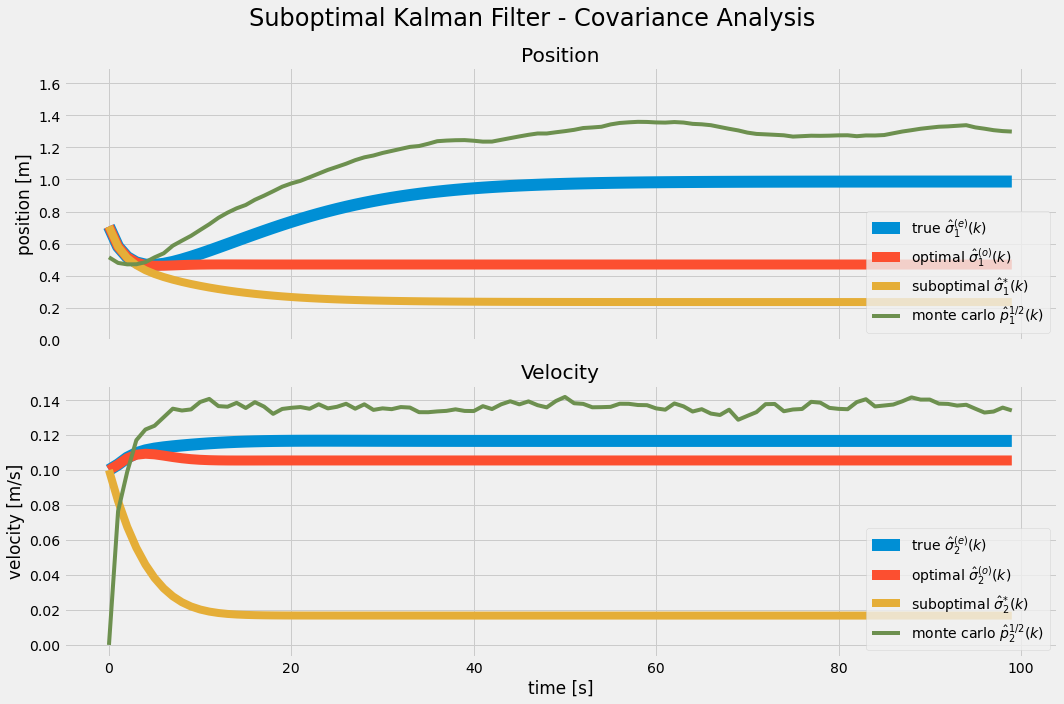

In [47]:
fig, axes = plt.subplots(ncols=1, nrows=2, sharex='col', sharey='row', figsize=(15,10))
fig.suptitle(r'Suboptimal Kalman Filter - Covariance Analysis', fontsize=24)

ax = axes[0]
ax.set_title(r'Position')
ax.plot(tm, sqrt(p_a[0]), lw=12)
ax.plot(tm, sqrt(p_hat_o[0]), lw=10)
ax.plot(tm, sqrt(p_hat_s[0]), lw=8)
ax.plot(tm, E_hat[:,0,:].std(axis=0))
ax.set_ylim((0,1.7))
ax.legend([r'true $\hat{\sigma}_1^{(e)}(k)$', r'optimal $\hat{\sigma}_1^{(o)}(k)$', r'suboptimal $\hat{\sigma}_1^{*}(k)$', r'monte carlo $\hat{p}_1^{1/2}(k)$'], loc='lower right')
ax.set_ylabel('position [m]')

ax = axes[1]
ax.set_title(r'Velocity')
ax.plot(tm, sqrt(p_a[1]), lw=12)
ax.plot(tm, sqrt(p_hat_o[1]), lw=10)
ax.plot(tm, sqrt(p_hat_s[1]), lw=8)
ax.plot(tm, E_hat[:,1,:].std(axis=0))
ax.legend([r'true $\hat{\sigma}_2^{(e)}(k)$', r'optimal $\hat{\sigma}_2^{(o)}(k)$', r'suboptimal $\hat{\sigma}_2^{*}(k)$', r'monte carlo $\hat{p}_2^{1/2}(k)$'], loc='lower right')
ax.set_xlabel('time [s]')
ax.set_ylabel('velocity [m/s]')

fig.tight_layout()
plt.show()